## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/rdelaviz/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/rdelaviz/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/rdelaviz/.fastai/data/camvid/images'),
 PosixPath('/home/rdelaviz/.fastai/data/camvid/labels')]

In [5]:
!head -n 4 /home/rdelaviz/.fastai/data/camvid/valid.txt

0016E5_07959.png
0016E5_07961.png
0016E5_07963.png
0016E5_07965.png


In [6]:
!head -n 5 /home/rdelaviz/.fastai/data/camvid/codes.txt

Animal
Archway
Bicyclist
Bridge
Building


In [7]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [8]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [9]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/rdelaviz/.fastai/data/camvid/images/0016E5_07975.png'),
 PosixPath('/home/rdelaviz/.fastai/data/camvid/images/0006R0_f03930.png'),
 PosixPath('/home/rdelaviz/.fastai/data/camvid/images/0016E5_00600.png')]

In [10]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/rdelaviz/.fastai/data/camvid/labels/Seq05VD_f02220_P.png'),
 PosixPath('/home/rdelaviz/.fastai/data/camvid/labels/0016E5_06090_P.png'),
 PosixPath('/home/rdelaviz/.fastai/data/camvid/labels/0016E5_06390_P.png')]

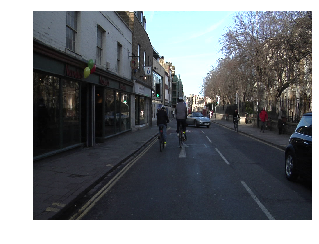

In [11]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [12]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

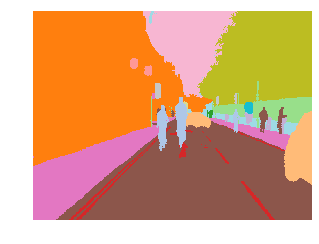

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [15]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [17]:
size = src_size//2
bs=8

In [18]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [26]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

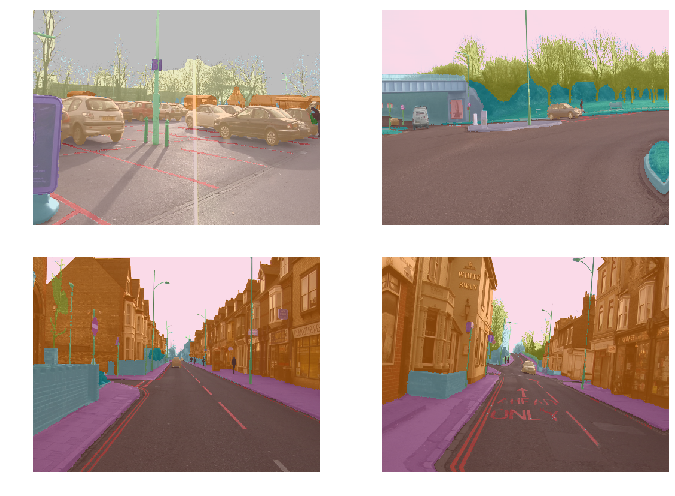

In [27]:
data.show_batch(2, figsize=(10,7))

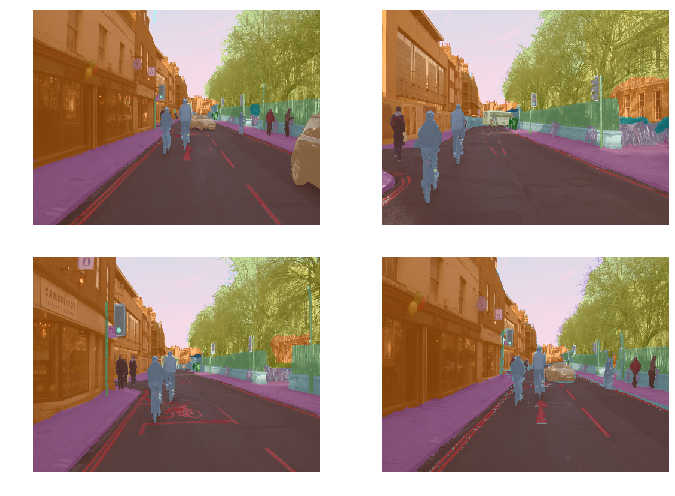

In [28]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [22]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [23]:
metrics=acc_camvid
# metrics=accuracy

In [24]:
wd=1e-2

In [35]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


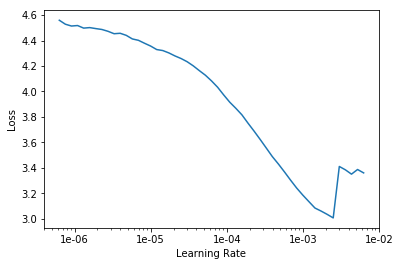

In [37]:
lr_find(learn)
learn.recorder.plot()

In [38]:
lr=3e-3

In [39]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.249957,0.825235,0.812253,00:51
1,0.835211,0.621655,0.831915,00:51
2,0.679261,0.511135,0.860275,00:52
3,0.640332,0.681277,0.831015,00:52
4,0.631809,0.449267,0.865196,00:51
5,0.757852,0.931136,0.786268,00:51
6,0.662224,0.508527,0.870284,00:51
7,0.568543,0.540288,0.862611,00:51
8,0.523646,0.375760,0.899520,00:51
9,0.460304,0.353088,0.895869,00:52


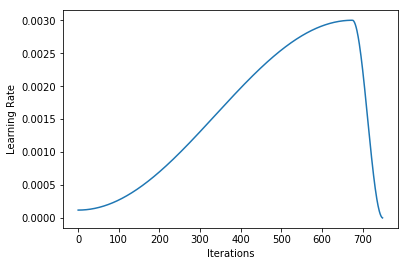

In [40]:
learn.recorder.plot_lr()

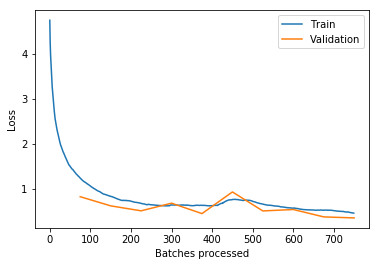

In [41]:
learn.recorder.plot_losses()

In [42]:
learn.save('stage-1')

In [43]:
learn.load('stage-1');

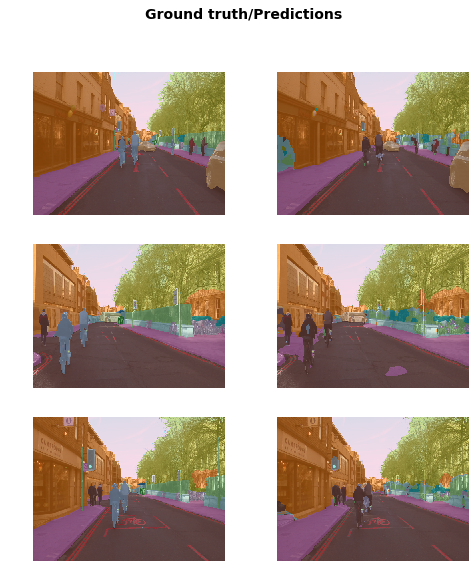

In [44]:
learn.show_results(rows=3, figsize=(8,9))

In [45]:
learn.unfreeze()

In [46]:
lrs = slice(lr/400,lr/4)

In [47]:
lrs

slice(7.5e-06, 0.00075, None)

In [48]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time


RuntimeError: CUDA out of memory. Tried to allocate 506.25 MiB (GPU 0; 10.92 GiB total capacity; 3.67 GiB already allocated; 359.50 MiB free; 55.39 MiB cached)

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [19]:
size = src_size
bs=3

In [25]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [26]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [27]:
learn.load('stage-1');

In [28]:
lr_find(learn)
learn.recorder.plot()

RuntimeError: CUDA out of memory. Tried to allocate 5.12 MiB (GPU 0; 10.92 GiB total capacity; 10.25 GiB already allocated; 3.50 MiB free; 2.98 MiB cached)

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

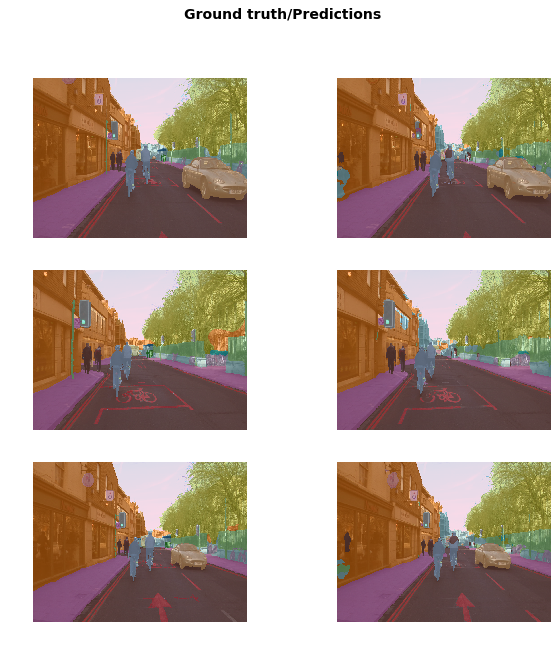

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin